# ML: Sentiment Analysis

Film Junky Union, a cutting-edge new community for classic movie fans, is developing a system for filtering and categorizing movie reviews.

The goal of the project is to train a model to detect negative reviews automatically. To achieve this, a dataset of IMDB movie reviews, from 1894 to 2010, with polarity legends is used to build a model and classify reviews as positive or negative. This model must reach an F1 score of at least 0.85.

## Initialization

In [1]:
#import libraries
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

from tqdm.auto import tqdm
import torch
import transformers

In [2]:
#matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load data and initial exploration

In [4]:
#Load data
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 47331 entries, 0 to 47330

Data columns (total 17 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   tconst           47331 non-null  object 

 1   title_type       47331 non-null  object 

 2   primary_title    47331 non-null  object 

 3   original_title   47331 non-null  object 

 4   start_year       47331 non-null  int64  

 5   end_year         47331 non-null  object 

 6   runtime_minutes  47331 non-null  object 

 7   is_adult         47331 non-null  int64  

 8   genres           47331 non-null  object 

 9   average_rating   47329 non-null  float64

 10  votes            47329 non-null  Int64  

 11  review           47331 non-null  object 

 12  rating           47331 non-null  int64  

 13  sp               47331 non-null  object 

 14  pos              47331 non-null  int64  

 15  ds_part          47331 non-null  object 

 16  idx              47331 non-null  int6

The dataset contains the following relevant data:
- `review` - the review text
- `pos` - target column, '0' for negative review and '1' for positive
- `ds_part` - specifies whether the information corresponds to the training set or the test set

In [6]:
#preview
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


 The `average_rating` and `votes` columns have missing values.
 
 The `end_year` and `runtime_minutes` columns contain numbers but are of type object.

In [8]:
#remove missing values
df_reviews = df_reviews.dropna()

#verify changes
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 47329 entries, 0 to 47330

Data columns (total 17 columns):

 #   Column           Non-Null Count  Dtype  

---  ------           --------------  -----  

 0   tconst           47329 non-null  object 

 1   title_type       47329 non-null  object 

 2   primary_title    47329 non-null  object 

 3   original_title   47329 non-null  object 

 4   start_year       47329 non-null  int64  

 5   end_year         47329 non-null  object 

 6   runtime_minutes  47329 non-null  object 

 7   is_adult         47329 non-null  int64  

 8   genres           47329 non-null  object 

 9   average_rating   47329 non-null  float64

 10  votes            47329 non-null  Int64  

 11  review           47329 non-null  object 

 12  rating           47329 non-null  int64  

 13  sp               47329 non-null  object 

 14  pos              47329 non-null  int64  

 15  ds_part          47329 non-null  object 

 16  idx              47329 non-null  int6

## Exploratory data analysis (EDA)

The number of films and reviews over the years are analyzed.

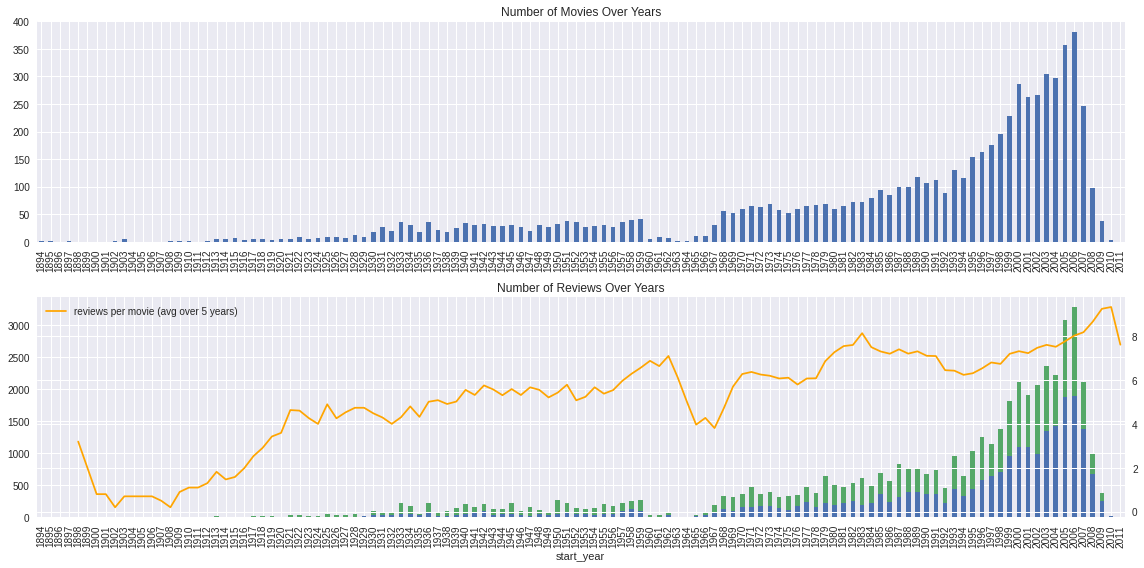

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2012))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2012))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2012))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The number of reviews per movie follows the trend of the number of movies per year. In the previous graphs, growth is observed from 1930 to 1959. After this there was a drop in numbers that increased in 1967.. After this year, the trend began to rise until reaching a peak in 2006. In the following years, the number of movies and reviews decreases.

The distribution of the number of reviews per movie is observed with the exact count and KDE (to see how it may differ from the exact count).

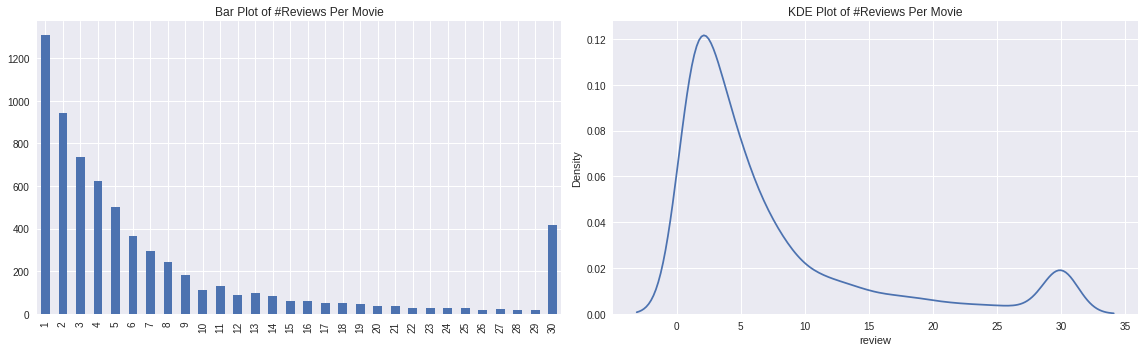

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most movies only have one review, as the number of reviews increases, the number of movies goes down. However, there is a significant number of movies with 30 reviews.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

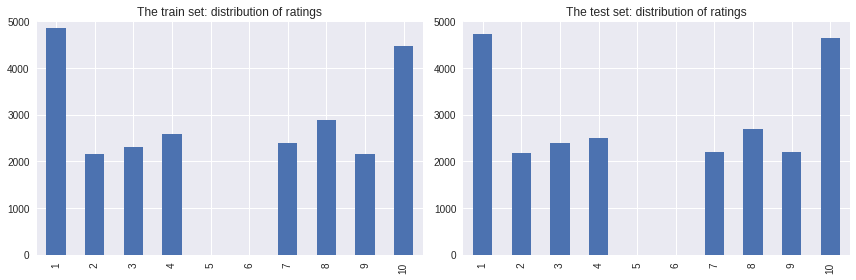

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [13]:
df_reviews['rating'].value_counts().sort_index()

1     9589
2     4339
3     4709
4     5078
7     4593
8     5576
9     4342
10    9103
Name: rating, dtype: int64

When looking at the ratings given to the movies, most are rated 1 or 10. There are no ratings of 5 or 6.

Distribution of negative and positive reviews over the years for two parts of the data set.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.

  warnings.warn(msg, UserWarning)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.

  warnings.warn(msg, UserWarning)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.

  warnings.warn(msg, UserWarning)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.

  warnings.warn(msg, UserWarning)


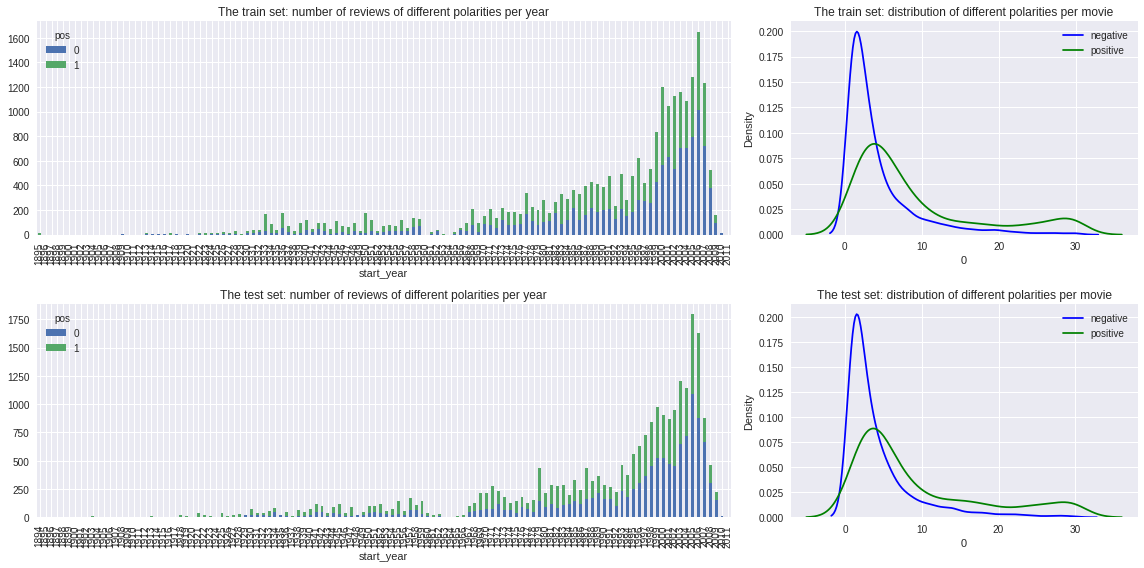

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2012))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')


ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2012))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The graphs above show similar data. In both it is observed that the negative reviews slightly exceed the positive ones.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
       # setting crosses for some thresholds 
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
#preserve letters, apostrophes and spaces; remove excess spaces with strip
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

## Train & Test Split

The data set is already divided into training & test parts in the `ds_part` column

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#set target column
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)

(23533, 18)


## Models

### Model 0 - Constant

A Dummy model is created to take it as a reference and compare it with the other models.

In [18]:
#set lemmatizer and stop words
lemmatizer  = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#lemmatizer function
def lem_nltk(df_column, lemmatizer, stop_words):
    list = []
    for review in df_column:
        #tokenize
        tokens = word_tokenize(review)
        
        #remove stop words
        tokens_stop = [token for token in tokens if not token in stop_words]
        
        #lemmatize tokens without stop words
        lemmas = [lemmatizer.lemmatize(token) for token in tokens_stop]
        lemmas_joined = " ".join(lemmas)
        list.append(lemmas_joined)
        
    return list 

In [19]:
#create features for training set
train_features0 = lem_nltk(df_reviews_train['review_norm'], lemmatizer, stop_words)

#create features for test set
test_features0 = lem_nltk(df_reviews_test['review_norm'], lemmatizer, stop_words)

In [20]:
#create model and train it
model_0 = DummyClassifier().fit(train_features0, train_target)

          train  test

Accuracy    0.5   0.5

F1          0.0   0.0

APS         0.5   0.5

ROC AUC     0.5   0.5


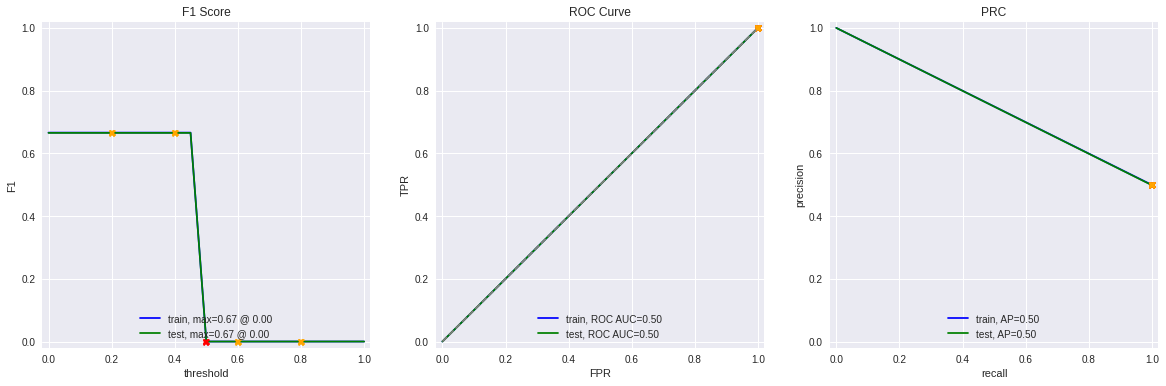

In [21]:
#evaluate model
evaluate_model(model_0, train_features0, train_target, test_features0, test_target)

The following models are expected to have better results in all metrics.

### Model 1 - NLTK, TF-IDF & LR

Logistic regression model using:
- Natural Language Toolkit (NLTK) as a library for tokenization and lemmatization
- Term frequency – Inverse document frequency values (TF-IDF) as characteristics

In [22]:
# training set features
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words))
train_features_1 = count_tf_idf.fit_transform(train_features0) 

#test set features
test_features_1 = count_tf_idf.transform(test_features0) 

#create model and train it
model_1 = LogisticRegression(random_state=12345) 
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345)

          train  test

Accuracy   0.94  0.88

F1         0.94  0.88

APS        0.98  0.95

ROC AUC    0.98  0.95


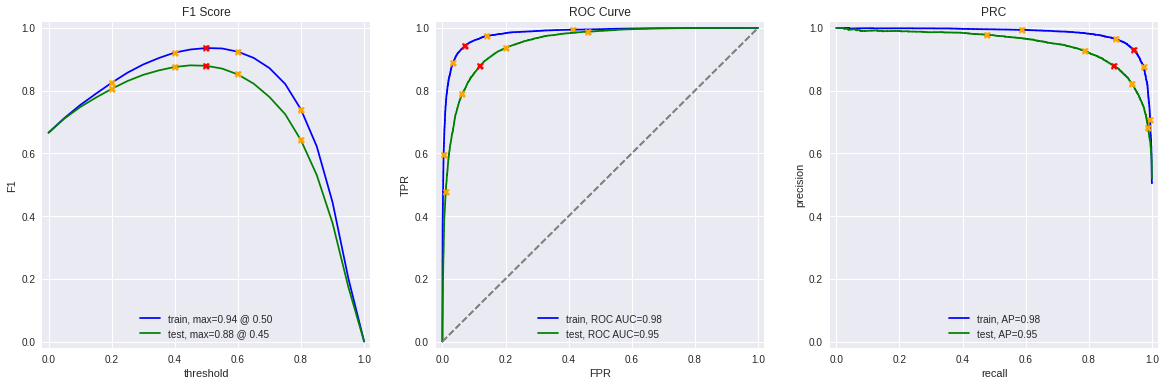

In [23]:
#evaluate model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

All metrics are better than those of the dummy model and the F1 score is greater than 0.85.

### Model 2 - spaCy, TF-IDF & LR

Logistic regression model using:
- spaCy as a library for tokenization and lemmatization
- Term frequency – Inverse document frequency values (TF-IDF) as characteristics

In [24]:
# load the small size model in English and disable some pipeline components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
# function to lemmatize with spacy
def lem_spacy(df_column):
    list = []
    for review in df_column:
        doc = nlp(review)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        list.append(' '.join(tokens))
        
    return list

In [26]:
#lemmatize training set
train_spacy2 = lem_spacy(df_reviews_train['review_norm'])

In [27]:
#lemmatize test set
test_spacy2 = lem_spacy(df_reviews_test['review_norm'])

In [28]:
count_tf_idf_spacy = TfidfVectorizer()

#training set features
train_features_2 = count_tf_idf_spacy.fit_transform(train_spacy2) 

#test set features
test_features_2 = count_tf_idf_spacy.transform(test_spacy2) 

In [29]:
#create model and train it
model_2 = LogisticRegression(random_state=12345) 
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test

Accuracy   0.93  0.87

F1         0.93  0.87

APS        0.98  0.94

ROC AUC    0.98  0.95


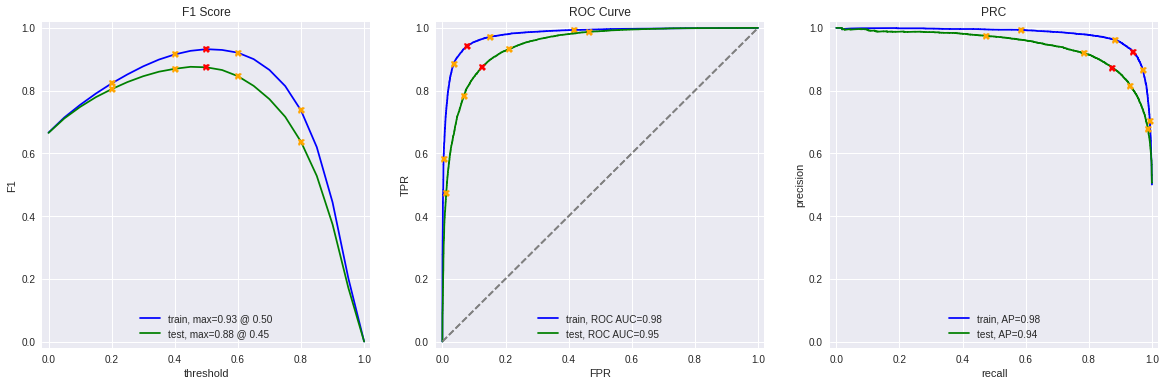

In [30]:
#evaluate model
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

The results are high, however those of the logistic regression model with NLTK are slightly better.

### Model 3 - spaCy, TF-IDF and LGBMClassifier with GridSearchCV
Model with LGBMClassifier using:
- parameters found with GridSearchCV
- spaCy as a library for tokenization and lemmatization
- Term frequency – Inverse document frequency values (TF-IDF) as characteristics

In [31]:
#Find the best parameters
parameters={'num_leaves':[10, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 40, 60],
            'objective':['binary'], 'random_state':[12345]}

grid=GridSearchCV(estimator=LGBMClassifier(), param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_2, train_target)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1],
                         'n_estimators': [10, 20, 40, 60],
                         'num_leaves': [10, 20], 'objective': ['binary'],
                         'random_state': [12345]},
             scoring='f1')

In [32]:
#create model and train it
model_3 = grid.best_estimator_
model_3.fit(train_features_2, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=60, num_leaves=20,
               objective='binary', random_state=12345)

          train  test

Accuracy   0.94  0.85

F1         0.94  0.85

APS        0.99  0.93

ROC AUC    0.99  0.93


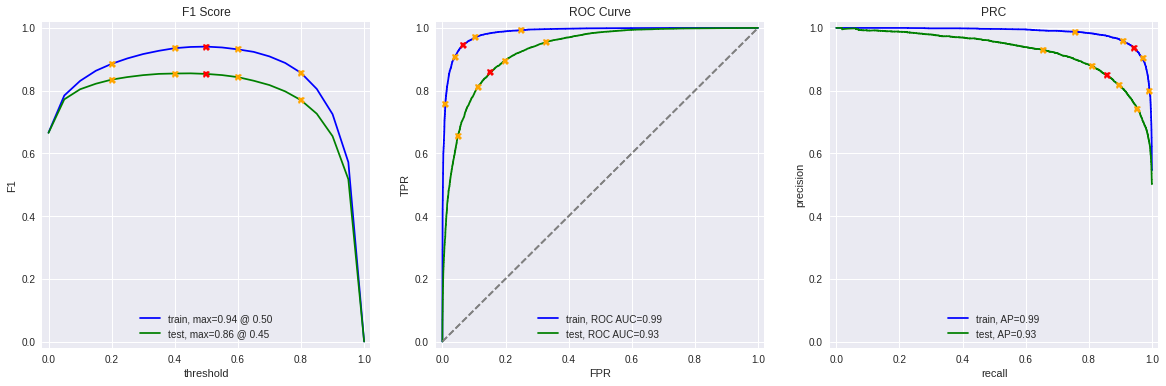

In [33]:
#evaluate model
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

## New reviews
The following reviews are taken to test the model again.

In [37]:
# new reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


#Normalization: preserve letters, apostrophes and spaces; remove excess spaces with strip
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


Positive review rates: 2, 4, 5, 7

Negative review rates: 0, 1, 3, 6

It is worth mentioning that in the review with index 5, a rating of 10 would not be expected (taking a rating of 0-10)

### Model 1

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it  not my kind of movie

0.16:  well  i was bored and felt asleep in the middle of the movie

0.55:  i was really fascinated with the movie

0.13:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so

0.35:  i didn t expect the reboot to be so good  writers really cared about the source material

0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my

0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki

0.88:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


The review with index 4 was marked as negative but it is positive. The same thing happened with index 5; This comes very close to being classified as a positive review but the text is not entirely positive.

### Model 2

In [39]:
my_rev_spacy = lem_spacy(my_reviews['review_norm'])

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it  not my kind of movie

0.08:  well  i was bored and felt asleep in the middle of the movie

0.50:  i was really fascinated with the movie

0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so

0.19:  i didn t expect the reboot to be so good  writers really cared about the source material

0.41:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my

0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki

0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


Again, reviews with index 4 and 5 were marked as negative but they are positive.

### Model 3

In [40]:
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  i did not simply like it  not my kind of movie

0.23:  well  i was bored and felt asleep in the middle of the movie

0.55:  i was really fascinated with the movie

0.36:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so

0.65:  i didn t expect the reboot to be so good  writers really cared about the source material

0.53:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my

0.23:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki

0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


The review with index 0 was marked as positive but is negative.

## Conclusions

With the exception of model 0, created as a Dummy model to use as a reference, all models showed acceptable metrics with F1 scores of at least 0.85.

The model with the best metrics is **Model 1**, this is a **logistic regression** model that uses:
- Natural Language Toolkit (NLTK) as a library for tokenization and lemmatization
- TF-IDF values as characteristics

          train  test

Accuracy   0.94  0.88

F1         0.94  0.88

APS        0.98  0.95

ROC AUC    0.98  0.95


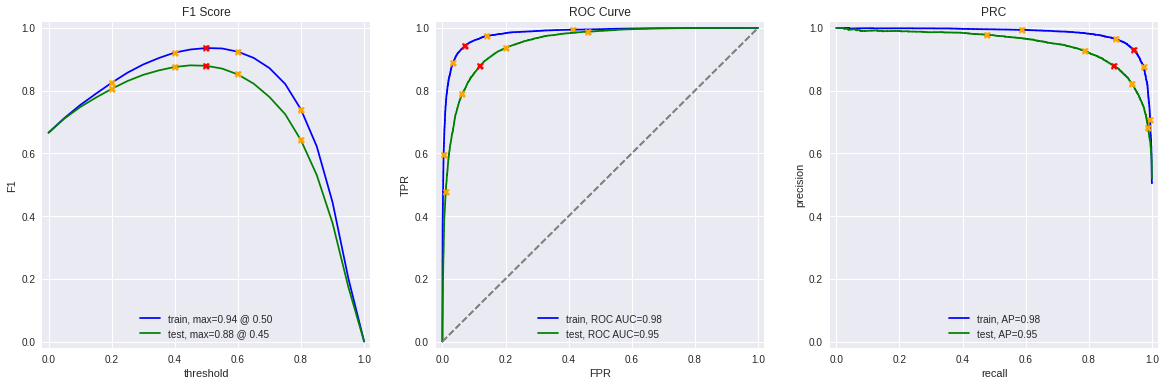

In [41]:
#Recommended model evaluation
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)